<a href="https://colab.research.google.com/github/alexanderwhatley/TCR-Pathogen-Identification/blob/master/benchmark_vdjdb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install serializable
!pip install mhcflurry
!pip install --no-cache-dir --force-reinstall --no-deps git+https://github.com/alexanderwhatley/pepnet
!pip install pepdata
!pip install biopython 
!mhcflurry-downloads fetch models_class1

  Cloning https://github.com/alexanderwhatley/pepnet to /tmp/pip-req-build-w2hjc0eg
  Found existing installation: pepnet 0.4.1
    Uninstalling pepnet-0.4.1:
      Successfully uninstalled pepnet-0.4.1
  Running setup.py install for pepnet ... done
****************************************
The requested download 'models_class1' has already been downloaded. To re-download this data, first run: 
	rm -rf /root/.local/share/mhcflurry/4/1.2.0/models_class1/
in a shell and then re-run this command.
****************************************
Fetching 0/10 downloads from release 1.2.0
DOWNLOAD NAME                             ALREADY DOWNLOADED?    WILL DOWNLOAD NOW?    URL                  
models_class1                             YES                    NO                    https://github.com/openvax/mhcflurry/releases/download/pre-1.2/models_class1.20180225.tar.bz2 
models_class1_selected_no_mass_spec       NO                     NO                    https://github.com/openvax/mhcflurry/rel

In [4]:
# Read in all necessary files 
import io
from google.colab import auth
from googleapiclient.discovery import build
from googleapiclient.http import MediaIoBaseDownload
auth.authenticate_user()
from google.colab import drive
drive.mount('/content/gdrive')

def download_file(name, file_id):
    drive_service = build('drive', 'v3')
    request = drive_service.files().get_media(fileId=file_id)
    downloaded = io.BytesIO()
    downloader = MediaIoBaseDownload(downloaded, request)
    done = False
    while done is False:
      status, done = downloader.next_chunk()
      print('Percent downloaded', int(100 * status.progress()))
    downloaded.seek(0)
    f = open(name, 'wb')
    f.write(downloaded.read())
    f.close()

download_file('vdjdb_data.tsv', '1Vzpw6hprVQjRbmM6wZXMeY3HQW-OuXlY')
download_file('sequences_combined.csv', '1X-LxheImPHtb-oH9hUn46kmOcwYJoXXf')
download_file('sequences_combined.fasta', '1sTJ48PGK-QRm0JrWm7uhfMK4s18uVgW5')
download_file('HIV.fasta', '1CDF0gCTBTYvjZXN8iGRo-sfy7QuONOdz')
download_file('HPV.fasta', '1-TjGSeWk2OSd7fIjGaWtjGRXV0GJBRHE')
download_file('Influenza.fasta', '1tD8Jro2e4n8uWudEJCqPXc61SmTsUlBh')
download_file('Japanese Encephalitis Virus.fasta', '1BxO_yWmepbro99gE_v6xNMhDbIZ3Gtaj')
download_file('HHV8.fasta', '19dQ4_w7KrJNSMb3bB_bM3Mk9f8gE7tiY')
download_file('Hepatitis A.fasta', '11wpCSWd1QFKyat6rNnslUSBCOe3I-ZAB')
download_file('Hepatitis B.fasta', '1I2Ok2Q0dwB9OjN8TxIo0mHcvhHacfVK8')
download_file('Hepatitis C.fasta', '1gIRF_95EQefBuBIT7NNDRoo7l54o9QGU')
download_file('Hepatitis E.fasta', '1KP4T_4mxm5qb51C9QUqyiDiE_SQZlLyx')
download_file('Measles.fasta', '1Evw1zekQDk7_19ivMa27eEpOO02zeXGP')
download_file('Rotavirus.fasta', '1Mrm-7dlqDhLjeuTAg_efTwkXE9FpW7Dx')
download_file('Norovirus.fasta', '1Y1QsowdgBoyyWg0S8H_SOxzLZTANLEym')
download_file('RSV.fasta', '1l3JoeY3ZVQAJZ6DAmdWQjWFkNRSXqHT7')
download_file('Dengue Virus.fasta', '1_JtXdF_1sr25KZWmT0YLo5UR7VbRbUG-')
download_file('Yellow Fever Virus.fasta', '1zEimcKA9LqUlc6K5yTzKSQcPkTHi2UFP')
download_file('HCV Data Combined.xlsx', '10W4xXXx0TReNrQ-P1WoUfuzcW114NioY')
download_file('uniprot-filtered-reviewed-human.fasta', '1lRALwQInvWtdUpVsgSiZnEhuTPbZJX6B')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Percent downloaded 100
Percent downloaded 100
Percent downloaded 100
Percent downloaded 100
Percent downloaded 100
Percent downloaded 100
Percent downloaded 100
Percent downloaded 100
Percent downloaded 100
Percent downloaded 100
Percent downloaded 100
Percent downloaded 100
Percent downloaded 100
Percent downloaded 100
Percent downloaded 100
Percent downloaded 100
Percent downloaded 100
Percent downloaded 100
Percent downloaded 100
Percent downloaded 100


In [5]:
# Build VDJDB model 
# Random Forest Model 
from collections import Counter, defaultdict
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from scipy.spatial.distance import hamming 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score, roc_curve, roc_auc_score, precision_recall_curve, accuracy_score
from pepnet.encoder import Encoder

encoder = Encoder()

# split data into training/validation by patient 
vdjdb_data = pd.read_csv('vdjdb_data.tsv', sep='\t')
vdjdb_data = vdjdb_data[['CDR3', 'Epitope', 'Meta', 'Reference']]
vdjdb_data = vdjdb_data[(vdjdb_data['CDR3'].str.len() <= 20) & 
                    (vdjdb_data['Epitope'].str.len() <= 11)]
vdjdb_data['Meta'] = vdjdb_data['Meta'].apply(lambda x: dict(json.loads(x)))
vdjdb_data['Subject_ID'] = vdjdb_data['Meta'].apply(lambda x: x['subject.id'])
num_blank_ids = vdjdb_data[vdjdb_data['Subject_ID'] == ''].shape[0]
vdjdb_data.loc[vdjdb_data['Subject_ID'] == '', 'Subject_ID'] = ['Patient ' + str(i + 10**6) for i in range(num_blank_ids)]
vdjdb_data_groupby = vdjdb_data.groupby(['Reference', 'Subject_ID']) # group corresponds to one patient 

np.random.seed(42)
prob_assigned = np.random.random(len(vdjdb_data_groupby))

def permute_patients():
  np.random.seed(42)
  train_data, train_labels, test_data, test_labels, train_patients, test_patients = [], [], [], [], [], []
  ctr = 0
  for ind, group in vdjdb_data_groupby:
    prob_assign = prob_assigned[ctr]
    ctr += 1
    positive_cdr3 = encoder.encode_onehot(group['CDR3'].values, max_peptide_length=20)
    positive_epitopes = encoder.encode_onehot(group['Epitope'].values, max_peptide_length=11)
    combined_positive_peptides = np.concatenate((positive_cdr3, positive_epitopes), axis=1)
    for i in range(len(combined_positive_peptides)):
      if prob_assign < 0.2:
        test_data.append(combined_positive_peptides[i].ravel())
        test_labels.append(1)
        test_patients.append(ind[1])
      else:
        train_data.append(combined_positive_peptides[i].ravel())
        train_labels.append(1)
        train_patients.append(ind[1])
    binding_complex = set([(row['CDR3'], row['Epitope']) for _, row in group.iterrows()])
    cdr3_distinct, epitope_distinct = set(group['CDR3']), set(group['Epitope'])
    if ind[1] != '':
      for epitope in epitope_distinct:
        for cdr3 in cdr3_distinct:
          if (cdr3, epitope) not in binding_complex:
            negative_cdr3 = encoder.encode_onehot([cdr3], max_peptide_length=20)[0]
            negative_epitope = encoder.encode_onehot([epitope], max_peptide_length=11)[0]
            combined_negative_peptide = np.concatenate((negative_cdr3, negative_epitope))
            if prob_assign < 0.2:
              test_data.append(combined_negative_peptide.ravel())
              test_labels.append(0)
              test_patients.append(ind[1])
            else:
              train_data.append(combined_negative_peptide.ravel())
              train_labels.append(0)
              train_patients.append(ind[1])
            
  return np.array(train_data), np.array(train_labels), np.array(test_data), np.array(test_labels), train_patients, test_patients

vdjdb_train_data, vdjdb_train_labels, vdjdb_test_data, vdjdb_test_labels, train_patients, test_patients = permute_patients()

Using TensorFlow backend.


 A C D E F G H I K L M N P Q R S T V W Y
['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']


Number of patients 5903


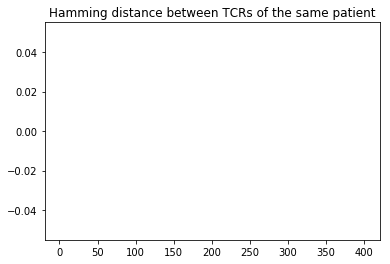

In [21]:
# make plot of pairwise hamming distances between TCRs of the same patient, to check for sequencing errors 
patient_to_ind = defaultdict(list)
for ind, patient in enumerate(train_patients):
  patient_to_ind[patient].append(ind)

print('Number of patients', len(patient_to_ind))
distances = Counter()
for patient in patient_to_ind:
  inds = patient_to_ind[patient]
  for i in range(len(inds)):
    for j in range(i):
      tcr1 = vdjdb_train_data[inds[i]][:20*20]
      tcr2 = vdjdb_train_data[inds[j]][:20*20]
      dist = int(hamming(tcr1, tcr2))
      if dist > 0:
        distances[dist] += 1

plt.title('Hamming distance between TCRs of the same patient')
plt.bar(range(1, 400+1), [distances[i] for i in range(1, 400+1)])
plt.show()

In [6]:
# train random forest model on VDJDB data 
print('Total samples', len(vdjdb_train_labels) + len(vdjdb_test_labels))
print('Positive samples', np.sum(vdjdb_train_labels == 1) + np.sum(vdjdb_test_labels == 1))
print('Negative samples', np.sum(vdjdb_train_labels == 0) + np.sum(vdjdb_test_labels == 0))
clf = RandomForestClassifier()
clf.fit(vdjdb_train_data, vdjdb_train_labels)

Total samples 23511
Positive samples 18529
Negative samples 4982


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [7]:
# read in human genome proteins, and generate negative epitope data from that (assume one epitope per protein, and that they are conserved)
from Bio import SeqIO

def is_epitope_valid(epitope):
  if 'U' not in epitope:
    return True
  return False 

lengths_total = []
for length in [8, 9, 10, 11]:
  lengths_total.append(vdjdb_data[vdjdb_data['Epitope'].str.len() == length].shape[0])
lengths_total = np.array(lengths_total)
lengths_prob = lengths_total / np.sum(lengths_total)

negative_epitopes = []
for seq_record in SeqIO.parse("uniprot-filtered-reviewed-human.fasta", "fasta"):
  if len(seq_record.seq) < 11:
    continue
  protein_seq = str(seq_record.seq)
  epitope_length = np.random.choice([8, 9, 10, 11], p=lengths_prob)
  epitope_start_ind = np.random.randint(len(protein_seq) - epitope_length)
  epitope = protein_seq[epitope_start_ind:(epitope_start_ind + epitope_length)]
  if is_epitope_valid(epitope):
    negative_epitopes.append(epitope)
  
negative_cdr3 = vdjdb_data['CDR3'].values[:len(negative_epitopes)].copy()
if len(negative_cdr3) < len(negative_epitopes):
  negative_epitopes = negative_epitopes[:len(negative_cdr3)]
negative_epitopes_encoded = encoder.encode_onehot(negative_epitopes, max_peptide_length=11)
negative_epitopes_encoded = negative_epitopes_encoded.reshape((len(negative_epitopes_encoded), -1))
negative_cdr3_encoded = encoder.encode_onehot(negative_cdr3, max_peptide_length=20)
negative_cdr3_encoded = negative_cdr3_encoded.reshape((len(negative_cdr3_encoded), -1))
combined_negative_peptides = np.concatenate((negative_cdr3_encoded, negative_epitopes_encoded), axis=1)

preds = clf.predict(combined_negative_peptides)
print('Accuracy for human epitope data', accuracy_score(np.zeros(len(combined_negative_peptides)), preds))

Accuracy for human epitope data 0.26747261050245563


## Compare Deep Learning model to Random Forest model

In [29]:
from pepnet import Predictor, SequenceInput, NumericInput, Output

def permute_patient_sequence_data():
  # permute the sequence data for the patients
  np.random.seed(42)
  train_seqs, train_labels, test_seqs, test_labels = [[], []], [], [[], []], []
  ctr = 0
  for ind, group in vdjdb_data_groupby:
    prob_assign = prob_assigned[ctr]
    ctr += 1
    positive_cdr3 = group['CDR3'].tolist()
    positive_epitopes = group['Epitope'].tolist()
    if prob_assign < 0.2:
      test_seqs[0] += positive_epitopes
      test_seqs[1] += positive_cdr3
      test_labels += [1] * len(positive_cdr3)
    else:
      train_seqs[0] += positive_epitopes
      train_seqs[1] += positive_cdr3
      train_labels += [1] * len(positive_cdr3)
    binding_complex = set([(row['CDR3'], row['Epitope']) for _, row in group.iterrows()])
    cdr3_distinct, epitope_distinct = set(group['CDR3']), set(group['Epitope'])
    if ind[1] != '':
      for epitope in epitope_distinct:
        for cdr3 in cdr3_distinct:
          if (cdr3, epitope) not in binding_complex:
            if prob_assign < 0.2:
              test_seqs[0].append(epitope)
              test_seqs[1].append(cdr3)
              test_labels.append(0)
            else:
              train_seqs[0].append(epitope)
              train_seqs[1].append(cdr3)
              train_labels.append(0)          
            
  return train_seqs, train_labels, test_seqs, test_labels

train_seqs, train_labels, test_seqs, test_labels = permute_patient_sequence_data()
train_epitopes, train_cdr3 = train_seqs
test_epitopes, test_cdr3 = test_seqs

predictor = Predictor(
    inputs=[
        SequenceInput(length=11, name="epitope", variable_length=True, encoding="onehot",
                     conv_filter_sizes={5: 3}),
        SequenceInput(length=20, name="CDR3", variable_length=True, encoding="onehot",
                      conv_filter_sizes={5: 3}
                     )],
    outputs=[Output(name="y", dim=1, activation="sigmoid")],
    merge_mode="concat",
    dense_layer_sizes=[30],
    dense_activation="relu")

# deep learning 
predictor.fit({'epitope': train_epitopes, 'CDR3': train_cdr3}, train_labels)
preds_dl = predictor.predict({'epitope': test_epitopes, 'CDR3': test_cdr3})['y'].ravel()
class_pred = np.rint(preds_dl)
print('Score on test set', accuracy_score(test_labels, class_pred))
print('Precision score', precision_score(test_labels, class_pred))
print('Confusion matrix', confusion_matrix(test_labels, class_pred))
print('AUC score for deep learning model', roc_auc_score(test_labels, preds_dl))

# random forest 
clf = RandomForestClassifier()
clf.fit(vdjdb_train_data, vdjdb_train_labels)
preds_rf = clf.predict(vdjdb_test_data)
print('AUC score for random forest', roc_auc_score(test_labels, preds_rf))

# see if ensembled data performs better 
ensemble_pred = (preds_rf + preds_dl) / 2
print('AUC score for ensemble', roc_auc_score(test_labels, ensemble_pred))

Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


epitope Tensor("Shape:0", shape=(2,), dtype=int32)
CDR3 Tensor("Shape_1:0", shape=(2,), dtype=int32)
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use tf.cast instead.


Epoch 1/100
19175/19175 [==============================] - 3s 151us/step - loss: 0.1407
Epoch 2/100
19175/19175 [==============================] - 2s 123us/step - loss: 0.1214
Epoch 3/100
19175/19175 [==============================] - 2s 111us/step - loss: 0.1150
Epoch 4/100
19175/19175 [==============================] - 2s 118us/step - loss: 0.1113
Epoch 5/100
19175/19175 [==============================] - 2s 124us/step - loss: 0.1091
Epoch 6/100
19175/19175 [==============================] - 2s 121us/step - loss: 0.1067
Epoch 7/100
19175/19175 [==============================] - 2s 107us/step - loss: 0.1050
Epoch 8/100
19175/19175 [==============================] - 2s 106us/step - loss: 0.1034
Epoch 9/100
19175/19175 [==============================] - 2s 107us/step - loss: 0.1014
Epoch 10/100
19175/19175 [==============================] - 2s 100us/step - loss: 0.0998
Epoch 11/100
19175/19175 [==============================] - 2s 103us/step - loss: 0.0991
Epoch 12/100
19175/19175 [====

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


AUC score for random forest 0.7740670714200683
AUC score for ensemble 0.8419854624902837


In [0]:
# functions that predict probability of binding given the (CDR3, Epitope) combinations 

def rf_proba(x):
  encoded_data = []
  for tcr, epitope in x:
    encoded_data.append(encode_data(tcr, epitope))
  encoded_data = np.array(encoded_data)
  bind_pred = clf.predict_proba(encoded_data)[:, 1]
  return bind_pred

def pepnet_proba(x):
  cdr3, epitopes = [], []
  for tcr, epitope in x:
    epitope = epitope.replace('X', 'A')
    tcr = tcr.replace('*', 'A')
    cdr3.append(tcr)
    epitopes.append(epitope)
  preds_pepnet = predictor.predict({'epitope': epitopes, 'CDR3': cdr3})['y'].ravel()
  return preds_pepnet 

def ensemble_proba(x):
  encoded_data = []
  cdr3, epitopes = [], []
  for tcr, epitope in x:
    epitope = epitope.replace('X', 'A')
    tcr = tcr.replace('*', 'A')
    encoded_data.append(encode_data(tcr, epitope))
    cdr3.append(tcr)
    epitopes.append(epitope)
  encoded_data = np.array(encoded_data)
  preds_rf = clf.predict_proba(encoded_data)[:, 1]
  preds_pepnet = predictor.predict({'epitope': epitopes, 'CDR3': cdr3})['y'].ravel()
  return (preds_rf + preds_pepnet) / 2

## Benchmark Performance of Original Metric 

In [24]:
from collections import defaultdict
import itertools
import os
import pickle
from Bio import SeqIO
from mhcflurry import Class1AffinityPredictor
import pandas as pd


# read in data from vdjdb 
vdjdb_data = pd.read_csv('vdjdb_data.tsv', sep='\t')
vdjdb_data = vdjdb_data[['CDR3', 'Epitope', 'Meta', 'Reference', 'MHC A']]
vdjdb_data = vdjdb_data[(vdjdb_data['CDR3'].str.len() <= 20) & 
                    (vdjdb_data['Epitope'].str.len() <= 11)]
mhc_alleles = vdjdb_data['MHC A'].unique()

# make predictions, using MHC alleles from vdjdb 
predictor = Class1AffinityPredictor.load()
virus_types = ['HIV', 'HPV', 'Influenza', 'Japanese Encephalitis Virus', 'HHV8', 'Hepatitis A', 
               'Hepatitis B', 'Hepatitis C', 'Hepatitis E', 'Measles', 'Rotavirus', 'Norovirus', 
               'RSV', 'Dengue Virus', 'Yellow Fever Virus']
def get_peptides(proteins, lengths=[8, 9, 10, 11]):
  virus_peptides = set()
  for length in lengths:
    for protein in proteins:
      for i in range(len(protein)-length):
        peptide = protein[i:i+length]
        virus_peptides.add(peptide)
        
  return list(virus_peptides) 

def process_mhc_alleles(mhc_alleles):
  processed = []
  for allele in mhc_alleles:
    split = allele.split(':')
    if len(split) >= 3:
      split = split[:2]
      allele = ':'.join(split)
    if 'HLA-A' in allele or 'HLA-B' in allele or 'HLA-C' in allele:
      processed.append(allele)
  return processed

virus_peptides = {}
peptide_to_virus = defaultdict(list)
for virus in virus_types:
  proteins = [str(seq_record.seq) for seq_record in SeqIO.parse(virus + ".fasta", "fasta")]
  print(virus, sum(len(seq) for seq in proteins))
  virus_peptides[virus] = get_peptides(proteins)
  for peptide in virus_peptides[virus]:
    peptide_to_virus[peptide].append(virus)

print('Processing peptides...')
all_peptides = set()
for virus in virus_peptides:
  all_peptides = all_peptides.union(set(virus_peptides[virus]))
all_peptides = list(all_peptides)

def get_affinities(mhc_alleles):
  supported_alleles = set(predictor.supported_alleles)
  alleles_to_predict = set(process_mhc_alleles(mhc_alleles))
  allele_intersection = supported_alleles.intersection(alleles_to_predict)
  epitope_affinities = {}
  for allele in allele_intersection:
    epitope_affinities[allele] = predictor.predict_to_dataframe(allele=allele, peptides=all_peptides)
    
  return epitope_affinities

HIV 3568
HPV 2652
Influenza 4557
Japanese Encephalitis Virus 4630
HHV8 38454
Hepatitis A 2227
Hepatitis B 1792
Hepatitis C 3173
Hepatitis E 2467
Measles 5202
Rotavirus 923
Norovirus 2507
RSV 3557
Dengue Virus 3392
Yellow Fever Virus 3411
Processing peptides...


In [0]:
# generate binding scores for all epitopes that can be generated in this dataset 
HCV_tcr_data = pd.read_excel('HCV Data Combined.xlsx')
HCV_tcr_data_groupby = HCV_tcr_data.groupby('Patient')
patient_tcr = []
alleles_by_patient = []
mhc_alleles = set()
for _, group in HCV_tcr_data_groupby:
  patient_tcr.append(group['CDR3'].tolist())
  patient_alleles = group['HLA Class I'].values[0].split(', ')
  alleles_by_patient.append(patient_alleles)
  mhc_alleles.update(patient_alleles)
mhc_alleles = list(mhc_alleles)

mhc_alleles = list(mhc_alleles)
if not os.path.isfile('/content/gdrive/My Drive/TCR Epitope Identification/epitope_affinities_HCV.pkl'):  
  epitope_affinities = get_affinities(mhc_alleles)
  pickle.dump(epitope_affinities, open('/content/gdrive/My Drive/TCR Epitope Identification/epitope_affinities_HCV.pkl', 'wb'))
else:
  epitope_affinities = pickle.load(open('/content/gdrive/My Drive/TCR Epitope Identification/epitope_affinities_HCV.pkl', 'rb'))

In [0]:
from IPython.display import display, HTML
from scipy.stats import binom_test 

def encode_data(tcr, epitope):
  epitope = epitope.replace('X', 'A')
  tcr = tcr.replace('*', 'A')
  cdr_encoded = encoder.encode_onehot([tcr], max_peptide_length=20)[0]
  epitope_encoded = encoder.encode_onehot([epitope], max_peptide_length=11)[0]
  combined_encoded = np.concatenate((cdr_encoded, epitope_encoded))
  combined_encoded = combined_encoded.ravel()
  return combined_encoded

def get_binding_epitopes(tcrs, patient_alleles, cutoff):
  combined_epitope_df = pd.concat([epitope_affinities[allele] for allele in epitope_affinities])
  binding_epitopes = combined_epitope_df[combined_epitope_df['prediction_percentile'] <= cutoff]
  patient_binding_epitopes = binding_epitopes['peptide'].unique()
  return patient_binding_epitopes

def make_dataframe(tcrs, virus_binding_peptides, predicted_to_bind_by_virus, cutoffs, background_rate):
  data = []
  for virus in virus_types:
    data.append({'Virus': virus, 'TCRs': len(tcrs), 'Binding Epitopes': len(virus_binding_peptides[virus]),
                 'TCR/Epitope Complexes': len(tcrs) * len(virus_binding_peptides[virus]), 
                 'Binding Prediction': predicted_to_bind_by_virus[virus], 'Background Prediction': background_rate * len(tcrs) * len(virus_binding_peptides[virus])})
  data = pd.DataFrame(data)
  data['Cutoff'] = cutoffs
  # perform a binomial test for each virus 
  background_prob = data['Binding Prediction'].sum() / data['TCR/Epitope Complexes'].sum()
  data['Binomial test p-value'] = data[['Binding Prediction', 'TCR/Epitope Complexes']].apply(lambda x: binom_test(int(x['Binding Prediction']), 
                                                                                                                   n=int(x['TCR/Epitope Complexes']), 
                                                                                                                   p=background_prob, alternative='greater'), axis=1)
  data = data[['Virus', 'TCRs', 'Binding Epitopes', 'TCR/Epitope Complexes', 'Binding Prediction', \
               'Background Prediction', 'Cutoff', 'Binomial test p-value']]
  
  return data 

def generate_metric_tables(patient_tcr, pred_func, log_weighted=False, cutoff=2):
  # create statistics tables for TCRs/epitopes
  for i in range(len(patient_tcr)):
    tcrs = patient_tcr[i]
    patient_alleles = alleles_by_patient[i]
    patient_binding_epitopes = get_binding_epitopes(tcrs, patient_alleles, cutoff)
    virus_binding_peptides = defaultdict(list)
    data = []
    for epitope in patient_binding_epitopes:
      for virus in peptide_to_virus[epitope]:
        virus_binding_peptides[virus].append(epitope)
    # calculate metric score for each virus  
    predicted_to_bind_by_virus = {}
    binding_scores_by_virus = {}
    total, total_positives = 0, 0
    cutoffs = []
    for virus in virus_types:
      virus_patient_binding_epitopes = virus_binding_peptides[virus]
      encoded_data = []
      for epitope, tcr in itertools.product(virus_patient_binding_epitopes, tcrs):
        encoded_data.append((tcr, epitope))
      if len(encoded_data) == 0:
        scores.append(0)
        continue
      bind_pred = pred_func(encoded_data)
      binding_scores_by_virus[virus] = bind_pred
      score = 0.909
      cutoffs.append(score)
      predicted_to_bind_by_virus[virus] = len(bind_pred[bind_pred > score])
      if log_weighted:
        num_positives = (bind_pred > score).sum()
        total += len(tcrs) * len(virus_binding_peptides[virus]) * np.log(num_positives)
        total_positives += num_positives * np.log(num_positives)
      else:
        total += len(tcrs) * len(virus_binding_peptides[virus])
        total_positives += (bind_pred > score).sum()

    background_rate = total_positives / total
    data = make_dataframe(tcrs, virus_binding_peptides, predicted_to_bind_by_virus, cutoffs, background_rate)
    print('Patient', i)
    display(data)

In [27]:
generate_metric_tables(patient_tcr, rf_proba, cutoff=2)

Patient 0


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Cutoff,Binomial test p-value
0,HIV,15,1453,21795,600,547.016425,0.909,1.237140e-02
1,HPV,15,1383,20745,481,520.663259,0.909,9.639608e-01
2,Influenza,15,1923,28845,663,723.959109,0.909,9.903689e-01
3,Japanese Encephalitis Virus,15,2004,30060,791,754.453486,0.909,9.261758e-02
4,HHV8,15,21866,327990,8121,8231.976010,0.909,8.934982e-01
5,Hepatitis A,15,1389,20835,518,522.922102,0.909,5.923223e-01
6,Hepatitis B,15,1078,16170,401,405.838751,0.909,6.029527e-01
7,Hepatitis C,15,1840,27600,864,692.711784,0.909,1.157955e-10
8,Hepatitis E,15,1314,19710,512,494.686567,0.909,2.210603e-01
9,Measles,15,2715,40725,853,1022.126355,0.909,1.000000e+00


Patient 1


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Cutoff,Binomial test p-value
0,HIV,6,1453,8718,206,154.776733,0.909,0.000042
1,HPV,6,1383,8298,158,147.320180,0.909,0.197617
2,Influenza,6,1923,11538,173,204.842159,0.909,0.990139
3,Japanese Encephalitis Virus,6,2004,12024,203,213.470456,0.909,0.774249
4,HHV8,6,21866,131196,2313,2329.214067,0.909,0.635510
5,Hepatitis A,6,1389,8334,115,147.959313,0.909,0.997982
6,Hepatitis B,6,1078,6468,110,114.830914,0.909,0.688133
7,Hepatitis C,6,1840,11040,237,196.000818,0.909,0.002263
8,Hepatitis E,6,1314,7884,118,139.970149,0.909,0.974785
9,Measles,6,2715,16290,295,289.207728,0.909,0.373508


Patient 2


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Cutoff,Binomial test p-value
0,HIV,70,1453,101710,2854,2495.440605,0.909,6.206800e-13
1,HPV,70,1383,96810,2462,2375.219791,0.909,3.710413e-02
2,Influenza,70,1923,134610,3122,3302.637497,0.909,9.993537e-01
3,Japanese Encephalitis Virus,70,2004,140280,3611,3441.750153,0.909,1.911830e-03
4,HHV8,70,21866,1530620,37935,37553.547332,0.909,2.340824e-02
5,Hepatitis A,70,1389,97230,2043,2385.524433,0.909,1.000000e+00
6,Hepatitis B,70,1078,75460,1637,1851.400532,0.909,9.999999e-01
7,Hepatitis C,70,1840,128800,3753,3160.089961,0.909,1.680032e-25
8,Hepatitis E,70,1314,91980,2202,2256.716418,0.909,8.806399e-01
9,Measles,70,2715,190050,3690,4662.850133,0.909,1.000000e+00


Patient 3


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Cutoff,Binomial test p-value
0,HIV,26,1453,37778,1097,968.270565,0.909,2.113754e-05
1,HPV,26,1383,35958,910,921.622981,0.909,6.554687e-01
2,Influenza,26,1923,49998,1204,1281.475772,0.909,9.869439e-01
3,Japanese Encephalitis Virus,26,2004,52104,1446,1335.453690,0.909,1.282472e-03
4,HHV8,26,21866,568516,14613,14571.372453,0.909,3.645478e-01
5,Hepatitis A,26,1389,36114,939,925.621345,0.909,3.324612e-01
6,Hepatitis B,26,1078,28028,622,718.372794,0.909,9.999082e-01
7,Hepatitis C,26,1840,47840,1414,1226.165065,0.909,5.859810e-08
8,Hepatitis E,26,1314,34164,867,875.641791,0.909,6.209896e-01
9,Measles,26,2715,70590,1457,1809.259865,0.909,1.000000e+00


Patient 4


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Cutoff,Binomial test p-value
0,HIV,43,1453,62479,2053,1750.208296,0.909,4.616512e-13
1,HPV,43,1383,59469,1679,1665.889934,0.909,3.756609e-01
2,Influenza,43,1923,82689,2091,2316.345873,0.909,9.999993e-01
3,Japanese Encephalitis Virus,43,2004,86172,2568,2413.914264,0.909,8.386074e-04
4,HHV8,43,21866,940238,26642,26338.647357,0.909,2.936068e-02
5,Hepatitis A,43,1389,59727,1489,1673.117222,0.909,9.999984e-01
6,Hepatitis B,43,1078,46354,1208,1298.502783,0.909,9.951594e-01
7,Hepatitis C,43,1840,79120,2576,2216.368386,0.909,2.166895e-14
8,Hepatitis E,43,1314,56502,1597,1582.776119,0.909,3.618904e-01
9,Measles,43,2715,116745,2565,3270.347918,0.909,1.000000e+00


In [37]:
generate_metric_tables(patient_tcr, ensemble_proba, log_weighted=True, cutoff=2)

Patient 0


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Cutoff,Binomial test p-value
0,HIV,15,1453,21795,2934,3339.820487,0.909,1.000000e+00
1,HPV,15,1383,20745,2859,3178.920670,0.909,1.000000e+00
2,Influenza,15,1923,28845,4098,4420.147830,0.909,1.000000e+00
3,Japanese Encephalitis Virus,15,2004,30060,5543,4606.331904,0.909,2.503823e-48
4,HHV8,15,21866,327990,49419,50260.505694,0.909,9.999893e-01
5,Hepatitis A,15,1389,20835,2629,3192.712083,0.909,1.000000e+00
6,Hepatitis B,15,1078,16170,2196,2477.857182,0.909,1.000000e+00
7,Hepatitis C,15,1840,27600,4978,4229.366618,0.909,2.083748e-34
8,Hepatitis E,15,1314,19710,3183,3020.319422,0.909,8.252269e-04
9,Measles,15,2715,40725,5355,6240.614331,0.909,1.000000e+00


Patient 1


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Cutoff,Binomial test p-value
0,HIV,6,1453,8718,1347,1517.009351,0.909,9.999996e-01
1,HPV,6,1383,8298,1375,1443.925625,0.909,9.807576e-01
2,Influenza,6,1923,11538,1947,2007.714372,0.909,9.412288e-01
3,Japanese Encephalitis Virus,6,2004,12024,2499,2092.282684,0.909,1.232736e-21
4,HHV8,6,21866,131196,22433,22829.268046,0.909,9.990094e-01
5,Hepatitis A,6,1389,8334,1141,1450.189944,0.909,1.000000e+00
6,Hepatitis B,6,1078,6468,1097,1125.489388,0.909,8.399672e-01
7,Hepatitis C,6,1840,11040,2311,1921.057953,0.909,1.253454e-21
8,Hepatitis E,6,1314,7884,1432,1371.885951,0.909,4.314285e-02
9,Measles,6,2715,16290,2521,2834.604534,0.909,1.000000e+00


Patient 2


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Cutoff,Binomial test p-value
0,HIV,70,1453,101710,12296,14081.016094,0.909,1.000000e+00
1,HPV,70,1383,96810,12707,13402.646426,0.909,1.000000e+00
2,Influenza,70,1923,134610,17491,18635.783860,0.909,1.000000e+00
3,Japanese Encephalitis Virus,70,2004,140280,23304,19420.754475,0.909,1.188888e-186
4,HHV8,70,21866,1530620,207993,211903.302068,0.909,1.000000e+00
5,Hepatitis A,70,1389,97230,10895,13460.792398,0.909,1.000000e+00
6,Hepatitis B,70,1078,75460,9879,10446.892876,0.909,1.000000e+00
7,Hepatitis C,70,1840,128800,21500,17831.431254,0.909,2.741290e-181
8,Hepatitis E,70,1314,91980,13554,12733.967754,0.909,9.875984e-15
9,Measles,70,2715,190050,22564,26311.052095,0.909,1.000000e+00


Patient 3


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Cutoff,Binomial test p-value
0,HIV,26,1453,37778,5356,6068.941026,0.909,1.000000e+00
1,HPV,26,1383,35958,5662,5776.562587,0.909,9.555417e-01
2,Influenza,26,1923,49998,7731,8032.053403,0.909,9.999095e-01
3,Japanese Encephalitis Virus,26,2004,52104,9944,8370.377025,0.909,6.642017e-75
4,HHV8,26,21866,568516,90084,91330.670671,0.909,9.999987e-01
5,Hepatitis A,26,1389,36114,4759,5801.623597,0.909,1.000000e+00
6,Hepatitis B,26,1078,28028,4133,4502.627960,0.909,1.000000e+00
7,Hepatitis C,26,1840,47840,8881,7685.376111,0.909,3.584816e-48
8,Hepatitis E,26,1314,34164,5740,5488.360983,0.909,1.393308e-04
9,Measles,26,2715,70590,9848,11340.106598,0.909,1.000000e+00


Patient 4


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Cutoff,Binomial test p-value
0,HIV,43,1453,62479,7865,8973.856086,0.909,1.000000e+00
1,HPV,43,1383,59469,8137,8541.529916,0.909,9.999993e-01
2,Influenza,43,1923,82689,11002,11876.617518,0.909,1.000000e+00
3,Japanese Encephalitis Virus,43,2004,86172,14614,12376.880658,0.909,1.638690e-99
4,HHV8,43,21866,940238,132837,135046.343552,0.909,1.000000e+00
5,Hepatitis A,43,1389,59727,6948,8578.586444,0.909,1.000000e+00
6,Hepatitis B,43,1078,46354,6636,6657.823029,0.909,6.372699e-01
7,Hepatitis C,43,1840,79120,13474,11364.002201,0.909,2.186308e-96
8,Hepatitis E,43,1314,56502,8620,8115.379833,0.909,1.474955e-09
9,Measles,43,2715,116745,14374,16768.079335,0.909,1.000000e+00


In [35]:
generate_metric_tables(patient_tcr, rf_proba, log_weighted=True, cutoff=2)

Patient 0


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Cutoff,Binomial test p-value
0,HIV,15,1453,21795,1205,1329.003338,0.909,9.998733e-01
1,HPV,15,1383,20745,1224,1264.977025,0.909,9.013453e-01
2,Influenza,15,1923,28845,1532,1758.894301,0.909,1.000000e+00
3,Japanese Encephalitis Virus,15,2004,30060,2094,1832.981893,0.909,7.334609e-10
4,HHV8,15,21866,327990,19478,19999.991051,0.909,9.999842e-01
5,Hepatitis A,15,1389,20835,1055,1270.464995,0.909,1.000000e+00
6,Hepatitis B,15,1078,16170,796,986.005230,0.909,1.000000e+00
7,Hepatitis C,15,1840,27600,2152,1682.977387,0.909,1.466230e-29
8,Hepatitis E,15,1314,19710,1278,1201.865373,0.909,1.572755e-02
9,Measles,15,2715,40725,2296,2483.306307,0.909,9.999744e-01


Patient 1


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Cutoff,Binomial test p-value
0,HIV,6,1453,8718,532,571.437853,0.909,9.657656e-01
1,HPV,6,1383,8298,527,543.908156,0.909,8.019911e-01
2,Influenza,6,1923,11538,671,756.280104,0.909,9.996282e-01
3,Japanese Encephalitis Virus,6,2004,12024,937,788.135896,0.909,8.669833e-08
4,HHV8,6,21866,131196,8343,8599.490768,0.909,9.992973e-01
5,Hepatitis A,6,1389,8334,466,546.267844,0.909,9.999056e-01
6,Hepatitis B,6,1078,6468,385,423.957333,0.909,9.809589e-01
7,Hepatitis C,6,1840,11040,899,723.637749,0.909,7.478239e-11
8,Hepatitis E,6,1314,7884,582,516.771740,0.909,2.411349e-03
9,Measles,6,2715,16290,1000,1067.758961,0.909,9.889508e-01


Patient 2


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Cutoff,Binomial test p-value
0,HIV,70,1453,101710,4548,5194.669758,0.909,1.000000e+00
1,HPV,70,1383,96810,4820,4944.410376,0.909,9.758347e-01
2,Influenza,70,1923,134610,5981,6874.982756,0.909,1.000000e+00
3,Japanese Encephalitis Virus,70,2004,140280,8512,7164.568614,0.909,6.790334e-56
4,HHV8,70,21866,1530620,75811,78173.880890,0.909,1.000000e+00
5,Hepatitis A,70,1389,97230,3853,4965.861180,0.909,1.000000e+00
6,Hepatitis B,70,1078,75460,3629,3853.994494,0.909,9.999498e-01
7,Hepatitis C,70,1840,128800,8636,6578.246631,0.909,2.889559e-135
8,Hepatitis E,70,1314,91980,4631,4697.726127,0.909,8.747646e-01
9,Measles,70,2715,190050,8610,9706.488915,0.909,1.000000e+00


Patient 3


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Cutoff,Binomial test p-value
0,HIV,26,1453,37778,1942,2265.458436,0.909,1.000000e+00
1,HPV,26,1383,35958,2210,2156.317287,0.909,1.404655e-01
2,Influenza,26,1923,49998,2625,2998.263299,0.909,1.000000e+00
3,Japanese Encephalitis Virus,26,2004,52104,3803,3124.555201,0.909,1.837817e-33
4,HHV8,26,21866,568516,33191,34092.576853,0.909,1.000000e+00
5,Hepatitis A,26,1389,36114,1685,2165.672242,0.909,1.000000e+00
6,Hepatitis B,26,1078,28028,1551,1680.773706,0.909,9.996668e-01
7,Hepatitis C,26,1840,47840,3631,2868.853078,0.909,7.792368e-45
8,Hepatitis E,26,1314,34164,2027,2048.735296,0.909,7.266912e-01
9,Measles,26,2715,70590,3963,4233.117450,0.909,9.999961e-01


Patient 4


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Cutoff,Binomial test p-value
0,HIV,43,1453,62479,3101,3431.550975,0.909,1.000000e+00
1,HPV,43,1383,59469,3283,3266.231932,0.909,4.300284e-01
2,Influenza,43,1923,82689,3826,4541.550257,0.909,1.000000e+00
3,Japanese Encephalitis Virus,43,2004,86172,5517,4732.848006,0.909,7.533086e-30
4,HHV8,43,21866,940238,50343,51640.945361,0.909,1.000000e+00
5,Hepatitis A,43,1389,59727,2639,3280.402136,0.909,1.000000e+00
6,Hepatitis B,43,1078,46354,2526,2545.913249,0.909,6.979281e-01
7,Hepatitis C,43,1840,79120,5289,4345.529108,0.909,1.533309e-45
8,Hepatitis E,43,1314,56502,3252,3103.274591,0.909,4.621687e-03
9,Measles,43,2715,116745,5932,6412.017134,0.909,1.000000e+00


In [33]:
generate_metric_tables(patient_tcr, ensemble_proba, cutoff=2)

Patient 0


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Cutoff,Binomial test p-value
0,HIV,15,1453,21795,2934,3342.008928,0.909,1.000000e+00
1,HPV,15,1383,20745,2859,3181.003680,0.909,1.000000e+00
2,Influenza,15,1923,28845,4098,4423.044163,0.909,1.000000e+00
3,Japanese Encephalitis Virus,15,2004,30060,5543,4609.350235,0.909,2.503823e-48
4,HHV8,15,21866,327990,49419,50293.439242,0.909,9.999893e-01
5,Hepatitis A,15,1389,20835,2629,3194.804130,0.909,1.000000e+00
6,Hepatitis B,15,1078,16170,2196,2479.480815,0.909,1.000000e+00
7,Hepatitis C,15,1840,27600,4978,4232.137940,0.909,2.083748e-34
8,Hepatitis E,15,1314,19710,3183,3022.298507,0.909,8.252269e-04
9,Measles,15,2715,40725,5355,6244.703537,0.909,1.000000e+00


Patient 1


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Cutoff,Binomial test p-value
0,HIV,6,1453,8718,1347,1518.818896,0.909,9.999996e-01
1,HPV,6,1383,8298,1375,1445.647993,0.909,9.807576e-01
2,Influenza,6,1923,11538,1947,2010.109248,0.909,9.412288e-01
3,Japanese Encephalitis Virus,6,2004,12024,2499,2094.778437,0.909,1.232736e-21
4,HHV8,6,21866,131196,22433,22856.499648,0.909,9.990094e-01
5,Hepatitis A,6,1389,8334,1141,1451.919785,0.909,1.000000e+00
6,Hepatitis B,6,1078,6468,1097,1126.831913,0.909,8.399672e-01
7,Hepatitis C,6,1840,11040,2311,1923.349463,0.909,1.253454e-21
8,Hepatitis E,6,1314,7884,1432,1373.522388,0.909,4.314285e-02
9,Measles,6,2715,16290,2521,2837.985756,0.909,1.000000e+00


Patient 2


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Cutoff,Binomial test p-value
0,HIV,70,1453,101710,12296,14093.033826,0.909,1.000000e+00
1,HPV,70,1383,96810,12707,13414.085190,0.909,1.000000e+00
2,Influenza,70,1923,134610,17491,18651.688952,0.909,1.000000e+00
3,Japanese Encephalitis Virus,70,2004,140280,23304,19437.329517,0.909,1.188888e-186
4,HHV8,70,21866,1530620,207993,212084.155297,0.909,1.000000e+00
5,Hepatitis A,70,1389,97230,10895,13472.280788,0.909,1.000000e+00
6,Hepatitis B,70,1078,75460,9879,10455.808992,0.909,1.000000e+00
7,Hepatitis C,70,1840,128800,21500,17846.649856,0.909,2.741290e-181
8,Hepatitis E,70,1314,91980,13554,12744.835821,0.909,9.875984e-15
9,Measles,70,2715,190050,22564,26333.507803,0.909,1.000000e+00


Patient 3


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Cutoff,Binomial test p-value
0,HIV,26,1453,37778,5356,6072.304823,0.909,1.000000e+00
1,HPV,26,1383,35958,5662,5779.764329,0.909,9.555417e-01
2,Influenza,26,1923,49998,7731,8036.505282,0.909,9.999095e-01
3,Japanese Encephalitis Virus,26,2004,52104,9944,8375.016425,0.909,6.642017e-75
4,HHV8,26,21866,568516,90084,91381.291988,0.909,9.999987e-01
5,Hepatitis A,26,1389,36114,4759,5804.839229,0.909,1.000000e+00
6,Hepatitis B,26,1078,28028,4133,4505.123606,0.909,1.000000e+00
7,Hepatitis C,26,1840,47840,8881,7689.635839,0.909,3.584816e-48
8,Hepatitis E,26,1314,34164,5740,5491.402985,0.909,1.393308e-04
9,Measles,26,2715,70590,9848,11346.392013,0.909,1.000000e+00


Patient 4


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Cutoff,Binomial test p-value
0,HIV,43,1453,62479,7865,8979.658170,0.909,1.000000e+00
1,HPV,43,1383,59469,8137,8547.052477,0.909,9.999993e-01
2,Influenza,43,1923,82689,11002,11884.296395,0.909,1.000000e+00
3,Japanese Encephalitis Virus,43,2004,86172,14614,12384.882982,0.909,1.638690e-99
4,HHV8,43,21866,940238,132837,135133.658329,0.909,1.000000e+00
5,Hepatitis A,43,1389,59727,6948,8584.132965,0.909,1.000000e+00
6,Hepatitis B,43,1078,46354,6636,6662.127672,0.909,6.372699e-01
7,Hepatitis C,43,1840,79120,13474,11371.349644,0.909,2.186308e-96
8,Hepatitis E,43,1314,56502,8620,8120.626866,0.909,1.474955e-09
9,Measles,43,2715,116745,14374,16778.920807,0.909,1.000000e+00


In [21]:
generate_metric_tables(patient_tcr, rf_proba, cutoff=1)

Patient 0


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Cutoff,Binomial test p-value
0,HIV,15,766,11490,352,295.069684,0.909,5.947722e-04
1,HPV,15,734,11010,297,282.743013,0.909,2.027363e-01
2,Influenza,15,995,14925,349,383.282422,0.909,9.655559e-01
3,Japanese Encephalitis Virus,15,1059,15885,429,407.935764,0.909,1.512489e-01
4,HHV8,15,12009,180135,4513,4625.968448,0.909,9.549218e-01
5,Hepatitis A,15,778,11670,314,299.692185,0.909,2.085962e-01
6,Hepatitis B,15,592,8880,226,228.043411,0.909,5.636805e-01
7,Hepatitis C,15,1001,15015,496,385.593673,0.909,2.619805e-08
8,Hepatitis E,15,698,10470,280,268.875508,0.909,2.539904e-01
9,Measles,15,1437,21555,408,553.544563,0.909,1.000000e+00


Patient 1


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Cutoff,Binomial test p-value
0,HIV,6,766,4596,122,84.832935,0.909,0.000075
1,HPV,6,734,4404,96,81.289001,0.909,0.058677
2,Influenza,6,995,5970,87,110.194217,0.909,0.990626
3,Japanese Encephalitis Virus,6,1059,6354,107,117.282087,0.909,0.842652
4,HHV8,6,12009,72054,1312,1329.972219,0.909,0.694265
5,Hepatitis A,6,778,4668,68,86.161911,0.909,0.981708
6,Hepatitis B,6,592,3552,47,65.562791,0.909,0.993514
7,Hepatitis C,6,1001,6006,137,110.858705,0.909,0.008471
8,Hepatitis E,6,698,4188,68,77.302074,0.909,0.870989
9,Measles,6,1437,8622,155,159.144815,0.909,0.640768


Patient 2


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Cutoff,Binomial test p-value
0,HIV,70,766,53620,1763,1364.452546,0.909,6.763748e-26
1,HPV,70,734,51380,1500,1307.451917,0.909,7.066526e-08
2,Influenza,70,995,69650,1719,1772.363294,0.909,9.029723e-01
3,Japanese Encephalitis Virus,70,1059,74130,1968,1886.364551,0.909,2.984979e-02
4,HHV8,70,12009,840630,21345,21391.267128,0.909,6.266242e-01
5,Hepatitis A,70,778,54460,1218,1385.827781,0.909,9.999985e-01
6,Hepatitis B,70,592,41440,845,1054.511628,0.909,1.000000e+00
7,Hepatitis C,70,1001,70070,2111,1783.050911,0.909,1.076480e-14
8,Hepatitis E,70,698,48860,1213,1243.326210,0.909,8.118166e-01
9,Measles,70,1437,100590,1831,2559.684475,0.909,1.000000e+00


Patient 3


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Cutoff,Binomial test p-value
0,HIV,26,766,19916,637,526.105426,0.909,0.000001
1,HPV,26,734,19084,573,504.127132,0.909,0.001227
2,Influenza,26,995,25870,660,683.387597,0.909,0.822584
3,Japanese Encephalitis Virus,26,1059,27534,812,727.344186,0.909,0.000930
4,HHV8,26,12009,312234,8161,8248.041860,0.909,0.835674
5,Hepatitis A,26,778,20228,565,534.347287,0.909,0.093915
6,Hepatitis B,26,592,15392,340,406.598450,0.909,0.999731
7,Hepatitis C,26,1001,26026,812,687.508527,0.909,0.000002
8,Hepatitis E,26,698,18148,438,479.401550,0.909,0.975039
9,Measles,26,1437,37362,730,986.962791,0.909,1.000000


Patient 4


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Cutoff,Binomial test p-value
0,HIV,43,766,32938,1189,949.820742,0.909,1.811230e-14
1,HPV,43,734,31562,1052,910.141546,0.909,1.679302e-06
2,Influenza,43,995,42785,1122,1233.774984,0.909,9.994965e-01
3,Japanese Encephalitis Virus,43,1059,45537,1321,1313.133375,0.909,4.166417e-01
4,HHV8,43,12009,516387,14873,14890.858077,0.909,5.601631e-01
5,Hepatitis A,43,778,33454,892,964.700440,0.909,9.921674e-01
6,Hepatitis B,43,592,25456,643,734.065116,0.909,9.997642e-01
7,Hepatitis C,43,1001,43043,1494,1241.214833,0.909,8.926049e-13
8,Hepatitis E,43,698,30014,871,865.502451,0.909,4.295077e-01
9,Measles,43,1437,61791,1283,1781.843872,0.909,1.000000e+00


In [36]:
generate_metric_tables(patient_tcr, ensemble_proba, cutoff=1)

Patient 0


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Cutoff,Binomial test p-value
0,HIV,15,766,11490,1626,1754.979342,0.909,9.996502e-01
1,HPV,15,734,11010,1455,1681.664278,0.909,1.000000e+00
2,Influenza,15,995,14925,2228,2279.640268,0.909,8.824845e-01
3,Japanese Encephalitis Virus,15,1059,15885,2933,2426.270396,0.909,7.468337e-28
4,HHV8,15,12009,180135,26750,27513.768825,0.909,9.999997e-01
5,Hepatitis A,15,778,11670,1447,1782.472491,0.909,1.000000e+00
6,Hepatitis B,15,592,8880,1225,1356.328682,0.909,9.999592e-01
7,Hepatitis C,15,1001,15015,2785,2293.386843,0.909,1.041040e-27
8,Hepatitis E,15,698,10470,1586,1599.184831,0.909,6.439589e-01
9,Measles,15,1437,21555,2719,3292.304588,0.909,1.000000e+00


Patient 1


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Cutoff,Binomial test p-value
0,HIV,6,766,4596,732,790.971632,0.909,9.904499e-01
1,HPV,6,734,4404,702,757.928431,0.909,9.884307e-01
2,Influenza,6,995,5970,987,1027.437042,0.909,9.203390e-01
3,Japanese Encephalitis Virus,6,1059,6354,1293,1093.523444,0.909,4.907902e-11
4,HHV8,6,12009,72054,12032,12400.493903,0.909,9.998715e-01
5,Hepatitis A,6,778,4668,598,803.362833,0.909,1.000000e+00
6,Hepatitis B,6,592,3552,639,611.299225,0.909,1.137253e-01
7,Hepatitis C,6,1001,6006,1322,1033.632642,0.909,8.435952e-22
8,Hepatitis E,6,698,4188,703,720.754829,0.909,7.719618e-01
9,Measles,6,1437,8622,1303,1483.846260,0.909,9.999999e-01


Patient 2


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Cutoff,Binomial test p-value
0,HIV,70,766,53620,6803,7434.484978,0.909,1.000000e+00
1,HPV,70,734,51380,6620,7123.905971,0.909,1.000000e+00
2,Influenza,70,995,69650,9240,9657.065996,0.909,9.999979e-01
3,Japanese Encephalitis Virus,70,1059,74130,12319,10278.224010,0.909,2.045431e-99
4,HHV8,70,12009,840630,113024,116554.477938,0.909,1.000000e+00
5,Hepatitis A,70,778,54460,6068,7550.952106,0.909,1.000000e+00
6,Hepatitis B,70,592,41440,5824,5745.711628,0.909,1.345004e-01
7,Hepatitis C,70,1001,70070,12357,9715.299560,0.909,1.667097e-171
8,Hepatitis E,70,698,48860,6596,6774.504588,0.909,9.906264e-01
9,Measles,70,1437,100590,11503,13946.938529,0.909,1.000000e+00


Patient 3


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Cutoff,Binomial test p-value
0,HIV,26,766,19916,2998,3211.582988,0.909,9.999841e-01
1,HPV,26,734,19084,2953,3077.417641,0.909,9.932482e-01
2,Influenza,26,995,25870,4163,4171.703750,0.909,5.610889e-01
3,Japanese Encephalitis Virus,26,1059,27534,5230,4440.034444,0.909,5.470489e-37
4,HHV8,26,12009,312234,49147,50349.739032,0.909,1.000000e+00
5,Hepatitis A,26,778,20228,2645,3261.894993,0.909,1.000000e+00
6,Hepatitis B,26,592,15392,2373,2482.058915,0.909,9.920946e-01
7,Hepatitis C,26,1001,26026,5072,4196.859753,0.909,4.266299e-47
8,Hepatitis E,26,698,18148,2847,2926.481626,0.909,9.471782e-01
9,Measles,26,1437,37362,4986,6024.862602,0.909,1.000000e+00


Patient 4


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Cutoff,Binomial test p-value
0,HIV,43,766,32938,4402,4786.272282,0.909,1.000000e+00
1,HPV,43,734,31562,4131,4586.323570,0.909,1.000000e+00
2,Influenza,43,995,42785,5828,6217.155248,0.909,1.000000e+00
3,Japanese Encephalitis Virus,43,1059,45537,7777,6617.052671,0.909,1.234757e-51
4,HHV8,43,12009,516387,72785,75037.002388,0.909,1.000000e+00
5,Hepatitis A,43,778,33454,3974,4861.253048,0.909,1.000000e+00
6,Hepatitis B,43,592,25456,3953,3699.051163,0.909,3.944619e-06
7,Hepatitis C,43,1001,43043,7775,6254.645632,0.909,1.160714e-90
8,Hepatitis E,43,698,30014,4442,4361.381270,0.909,9.494996e-02
9,Measles,43,1437,61791,7608,8978.946826,0.909,1.000000e+00


In [22]:
generate_metric_tables(patient_tcr, rf_proba, cutoff=0.5)

Patient 0


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Cutoff,Binomial test p-value
0,HIV,15,398,5970,181,157.885609,0.909,3.620965e-02
1,HPV,15,373,5595,157,147.968172,0.909,2.365662e-01
2,Influenza,15,520,7800,209,206.282706,0.909,4.335608e-01
3,Japanese Encephalitis Virus,15,550,8250,223,218.183631,0.909,3.797956e-01
4,HHV8,15,6382,95730,2425,2531.723516,0.909,9.850586e-01
5,Hepatitis A,15,435,6525,181,172.563417,0.909,2.676517e-01
6,Hepatitis B,15,331,4965,131,131.306876,0.909,5.229053e-01
7,Hepatitis C,15,517,7755,278,205.092613,0.909,5.360005e-07
8,Hepatitis E,15,360,5400,151,142.811104,0.909,2.546945e-01
9,Measles,15,764,11460,231,303.076899,0.909,9.999946e-01


Patient 1


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Cutoff,Binomial test p-value
0,HIV,6,398,2388,65,44.797224,0.909,0.002457
1,HPV,6,373,2238,57,41.983328,0.909,0.014883
2,Influenza,6,520,3120,57,58.529036,0.909,0.597910
3,Japanese Encephalitis Virus,6,550,3300,55,61.905712,0.909,0.828613
4,HHV8,6,6382,38292,692,718.331366,0.909,0.843948
5,Hepatitis A,6,435,2610,34,48.961790,0.909,0.990351
6,Hepatitis B,6,331,1986,33,37.255983,0.909,0.781334
7,Hepatitis C,6,517,3102,68,58.191369,0.909,0.110785
8,Hepatitis E,6,360,2160,31,40.520102,0.909,0.948901
9,Measles,6,764,4584,88,85.992661,0.909,0.428160


Patient 2


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Cutoff,Binomial test p-value
0,HIV,70,398,27860,910,716.279355,0.909,1.022569e-12
1,HPV,70,373,26110,834,671.286934,0.909,4.608923e-10
2,Influenza,70,520,36400,917,935.842374,0.909,7.380933e-01
3,Japanese Encephalitis Virus,70,550,38500,1043,989.833280,0.909,4.583417e-02
4,HHV8,70,6382,446740,11489,11485.665444,0.909,4.887158e-01
5,Hepatitis A,70,435,30450,711,782.868140,0.909,9.960397e-01
6,Hepatitis B,70,331,23170,519,595.699665,0.909,9.994605e-01
7,Hepatitis C,70,517,36190,1070,930.443283,0.909,3.119501e-06
8,Hepatitis E,70,360,25200,576,647.890874,0.909,9.983037e-01
9,Measles,70,764,53480,969,1374.968411,0.909,1.000000e+00


Patient 3


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Cutoff,Binomial test p-value
0,HIV,26,398,10348,323,276.910976,0.909,3.294136e-03
1,HPV,26,373,9698,311,259.517071,0.909,8.949494e-04
2,Influenza,26,520,13520,356,361.793235,0.909,6.285043e-01
3,Japanese Encephalitis Virus,26,550,14300,421,382.665922,0.909,2.629077e-02
4,HHV8,26,6382,165932,4327,4440.316209,0.909,9.587375e-01
5,Hepatitis A,26,435,11310,325,302.653957,0.909,1.024867e-01
6,Hepatitis B,26,331,8606,201,230.295310,0.909,9.784929e-01
7,Hepatitis C,26,517,13442,470,359.705967,0.909,9.677385e-09
8,Hepatitis E,26,360,9360,197,250.472240,0.909,9.998279e-01
9,Measles,26,764,19864,440,531.557754,0.909,9.999843e-01


Patient 4


,Virus,TCRs,Binding Epitopes,TCR/Epitope Complexes,Binding Prediction,Background Prediction,Cutoff,Binomial test p-value
0,HIV,43,398,17114,601,509.405712,0.909,3.247300e-05
1,HPV,43,373,16039,573,477.407865,0.909,8.775958e-06
2,Influenza,43,520,22360,646,665.555201,0.909,7.843315e-01
3,Japanese Encephalitis Virus,43,550,23650,708,703.952616,0.909,4.436901e-01
4,HHV8,43,6382,274426,8179,8168.410179,0.909,4.541925e-01
5,Hepatitis A,43,435,18705,506,556.762524,0.909,9.872217e-01
6,Hepatitis B,43,331,14233,394,423.651484,0.909,9.328014e-01
7,Hepatitis C,43,517,22231,820,661.715459,0.909,9.023107e-10
8,Hepatitis E,43,360,15480,421,460.768985,0.909,9.728812e-01
9,Measles,43,764,32852,700,977.854180,0.909,1.000000e+00


## Permutation Metric

Construct a p-value distribution in a different way: first, for a particular virus, standardize the proportion of epitopes presented by an HLA allele. Then, shuffle the HLA alleles in a patient using only the set of HLA alleles that the patient does not have. Compute the empirical p-value for the number of predicted binders according to this permutation distribution for each virus.